# Data Exploration

Protocol buffer parsing Inspired by
https://stackoverflow.com/questions/38958751/parsing-nyc-transit-mta-historical-gtfs-data-not-realtime

This extracts data from the protobufs manually downloaded from [MTA Alert Archive](http://web.mta.info/developers/data/archives.html)the latest source suggested at:
https://groups.google.com/d/msg/mtadeveloperresources/Whm5XTVINcE/z-LO12ANAAAJ

**NOTE:** You'll first need to download and extract data.  See [Data README](../docs/Data_README.md), [StatusExtractor.ipynb](StatusExtractor.ipynb) and [AlertScraper.ipynb] This expects data to have been downloaded under <code>data/raw/status</code> and <code>data/raw/alerts</code>

In [9]:
import os
import sys
data_dir = '../data/raw/status'
protobuf_dir = '../MTADelayPredict/protobuf'

In [10]:
proto_file = os.path.join(os.path.join(protobuf_dir), 'gtfs-realtime.proto')
#! wget -O $proto_file https://developers.google.com/transit/gtfs-realtime/gtfs-realtime.proto

In [11]:
proto_file = os.path.join(os.path.join(protobuf_dir), 'nyct-subway.proto')
#! wget -O $proto_file https://api.mta.info/nyct-subway.proto.txt

In [12]:
#! protoc -I $protobuf_dir --python_out=$protobuf_dir $protobuf_dir/nyct-subway.proto $protobuf_dir/gtfs-realtime.proto

## Examine Alerts

First, fetch the alert from the downloaded alert data.

### Load alert historical data

In [13]:
import pandas as pd
import numpy as np
import os 

In [18]:
alert_dir = '../data/raw/alerts'
annotated_alert_df = pd.read_csv(os.path.abspath(os.path.join(alert_dir, 'nqrw_alerts.csv')))

In [19]:
annotated_alert_df[annotated_alert_df.Direction == 'Northbound']

,Date,Agency,Subject,Direction,IssueStop,AffectedTrains,Affected Stops,Alternate Line,Message
0,2018-08-01 13:07:00,NYC,"MANH, N, Q, R and W Trains, Unauthorized perso...",Northbound,NaN,R,"57 St 7-Av,Lexington Av-63 St",NaN,Some northbound R trains are stopping along th...
1,2018-08-01 13:26:00,NYC,"UPDATED: MANH, N, Q, R and W Trains, Unauthori...",Northbound,NaN,R,"57 St 7-Av,Lexington Av-63 St",NaN,Some northbound R trains are stopping along th...
6,2018-08-05 19:53:00,NYC,"UPDATED: MANH, N and R Trains, Signal problems",Northbound,49 St.,"N, Q, R, W","Canal St,Times Sq-42 St",NaN,Northbound N and R trains are running express ...
28,2018-08-10 19:53:00,NYC,"MANH, N and R Trains, Signal Problems",Northbound,Lexington Av-59,"N,R","57 St 7-Av,96 St",NaN,Some northbound N trains are stopping along th...
29,2018-08-12 09:00:00,NYC,"UPDATED: BKLYN, D, N, R Trains, Signal Problem",Northbound,53 St (BKLYN),"D,N,R",NaN,NaN,"Northbound D, N and R trains are running with ..."
...,...,...,...,...,...,...,...,...,...
283,2018-12-06 16:02:00,NYC,"UPDATED: BKLYN, D, N and R Trains, FDNY Activity",Northbound,36 St (Bklyn),"D, N, R","Coney Island-Stillwell Av,36 St (Brooklyn)",Local,"D, N and R train service has resumed with dela..."
286,2018-12-07 08:10:00,NYC,"MANH, N and Q Trains, Medical Assistance",Northbound,Canal St.,"N,Q",NaN,NaN,Northbound N and Q trains are running with del...
287,2018-12-07 17:40:00,NYC,"MANH, N, Q, R and W Trains, Unauthorized Perso...",Northbound,8 St-NYU.,"R,W","Canal St,34 St-Herald Sq",Express,Northbound R and W trains are running express ...
288,2018-12-07 18:10:00,NYC,"UPDATED: MANH, N, Q, R and W Trains, Unauthori...",Northbound,8 St-NYU.,"R, W","Canal St,34 St-Herald Sq",Express,Northbound R and W trains are now making local...


In [20]:
alert_dir = '../data/raw/alerts'
alert_df = pd.read_csv(os.path.abspath(os.path.join(alert_dir, 'raw_alerts_12.01.2018_12.31.2018.csv')))
alert_df.index = alert_df.Date.map(pd.to_datetime)
alert_df.drop(columns=['Date'], inplace=True)
alert_df.sort_index(inplace=True)

In [21]:
alert_df.head(10)

,Agency,Subject,Message
Date,,,
2018-12-01 00:25:00,NYC,"UPDATED: MANH, A Trains, NYPD Activity",Northbound A train service has resumed after e...
2018-12-01 00:34:00,NYC,"BKLYN, 2 and 4 Trains, Rail Replacement.",Northbound 2 and 4 trains are running express ...
2018-12-01 00:55:00,NYC,"MANH, 1 Trains, Vandalism.",Northbound 1 trains are delayed while we remov...
2018-12-01 00:57:00,NYC,"UPDATED: MANH, 1 Trains, Vandalism.",Northbound 1 train service has resumed after w...
2018-12-01 00:58:00,NYC,"UPDATED: MANH, 1 Trains, Vandalism.",Northbound 1 trains are no longer delayed afte...
2018-12-01 01:35:00,NYC,"BX, 4 Trains, Track Maintenance.",Southbound 4 trains are bypassing 138 St-Grand...
2018-12-01 01:45:00,NYC,"MANH, 2 Trains, Track Maintenance.",Southbound 2 trains are running express from 9...
2018-12-01 02:21:00,NYC,"MANH, N and Q, Trains, Brakes Activated.",Northbound N and Q trains are holding in stati...
2018-12-01 02:27:00,NYC,"UPDATED: MANH, N and Q, Trains, Brakes Activated.",Northbound N and Q train service has resumed a...


### Load subway gtfs statuses from this time period

Also download stop ID's to make this more easily explorable

In [22]:
#!wget -O $data_dir/Stations.csv http://web.mta.info/developers/data/nyct/subway/Stations.csv 
stations_df = pd.read_csv(data_dir + '/Stations.csv')
stations_df.index = stations_df['GTFS Stop ID']

In [23]:
# We are looking for station R16 aka Times Sq - 42 St
stations_df.loc['R16']

Station ID                                11
Complex ID                               611
GTFS Stop ID                             R16
Division                                 BMT
Line                     Broadway - Brighton
Stop Name                   Times Sq - 42 St
Borough                                    M
Daytime Routes                       N Q R W
Structure                             Subway
GTFS Latitude                        40.7547
GTFS Longitude                      -73.9868
North Direction Label        Uptown & Queens
South Direction Label    Downtown & Brooklyn
Name: R16, dtype: object

In [24]:
# Download some other stuff we need for processing data
#!wget -O $data_dir/google_transit.zip http://web.mta.info/developers/data/nyct/subway/google_transit.zip
#import zipfile
#with zipfile.ZipFile(data_dir+'/google_transit.zip') as zf:
#    zf.extractall(data_dir+'/google_transit')

In [25]:
stop_ids = pd.read_csv(data_dir+'/google_transit/stops.txt')

In [26]:
STOP_FILTER = '^R60N$'
stop_ids[stop_ids['stop_id'].str.match(STOP_FILTER)].stop_id

Series([], Name: stop_id, dtype: object)

In [27]:
! ls $data_dir/google_transit

agency.txt    calendar_dates.txt  shapes.txt	  stops.txt	 trips.txt
calendar.txt  routes.txt	  stop_times.txt  transfers.txt


## Parse Protobufs
Have a look at what is actually in these messages.

A great writeup of the mta gtfs feed contents can be found here: https://www.residentmar.io/2018/01/29/gtfs-tripify.html

In [28]:
import sys
sys.path.append(os.path.join(data_dir))
import nyct_subway_pb2
import gtfs_realtime_pb2

In [29]:
msg = gtfs_realtime_pb2.FeedMessage()

with open(os.path.join(data_dir, '201812/20181209/gtfs_nqrw_20181209_042657.gtfs'),'rb') as fh:
    msg.ParseFromString(fh.read())

In [30]:
print(msg)

header {
  gtfs_realtime_version: "1.0"
  incrementality: FULL_DATASET
  timestamp: 1544347617
  [nyct_feed_header] {
    nyct_subway_version: "1.0"
    trip_replacement_period {
      route_id: "N"
      replacement_period {
        end: 1544349417
      }
    }
    trip_replacement_period {
      route_id: "W"
      replacement_period {
        end: 1544349417
      }
    }
    trip_replacement_period {
      route_id: "Q"
      replacement_period {
        end: 1544349408
      }
    }
    trip_replacement_period {
      route_id: "R"
      replacement_period {
        end: 1544349404
      }
    }
  }
}
entity {
  id: "16000001"
  trip_update {
    trip {
      trip_id: "020158_N..S"
      start_date: "20181209"
      route_id: "N"
      [nyct_trip_descriptor] {
        train_id: "1N 0318+ QBP/STL"
        is_assigned: true
        direction: SOUTH
      }
    }
    stop_time_update {
      arrival {
        time: 1544347607
      }
      departure {
        time: 1544347607
      

## Calculate Wait Times

This requires [StatusExtractor.ipynb](StatusExctractor.ipynb) to have been run and dumped h5 data to disk.

In [31]:
# relative MTADelayPredict Project
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.path.realpath(os.path.join('DataExploration.ipynb')))))
from MTADelayPredict.utils import gtfs_loader

from importlib import reload


In [32]:
import glob
import pandas as pd

#status_files = glob.glob(os.path.join(data_dir, 'status_*.h5'))
#status_files = glob.glob(os.path.join(data_dir, 'status_201808.h5'))
status_files = glob.glob(os.path.join(data_dir, 'status_northbound_n_20181*.h5'))
stopped_at = []
next_train = []
next_scheduled_arrival = []

for f in status_files:
    stopped_at.append(pd.read_hdf(f, key='stopped_at'))
    next_train.append(pd.read_hdf(f, key='next_train'))
    next_scheduled_arrival.append(pd.read_hdf(f, key='next_scheduled_arrival'))
stopped_at_df = pd.concat(stopped_at)
next_train_df = pd.concat(next_train)
next_scheduled_arrival_df = pd.concat(next_scheduled_arrival)

### How Frequently do we get updates, and what time of day?

In [33]:
stopped_at_df = stopped_at_df.sort_index()
next_train_df = next_train_df.sort_index()
next_scheduled_arrival_df = next_scheduled_arrival_df.sort_index()

In [34]:
# Gap between times
stopped_at_df['time'] = stopped_at_df.index
time_till_next_obs = pd.DataFrame(columns=['time'])
# There is generally a gap between end of day and start of day, or if there are missing day
# we need to calculate time until next train within each day and not accidentally count overnight
deltas = []

times_sq_df = stopped_at_df[['time', 'R16N']].replace(0.0, np.nan).dropna()

for _,d in times_sq_df.groupby(times_sq_df.index.date):
    deltas.append((d.time.shift(-1) - d.time).to_frame())
#for _,d in new_stops.groupby(new_stops.index.date):
#    time_till_next_obs.loc[d.index, 'time'] = d.time.shift(-1) - d.time

time_till_next_obs = pd.concat(deltas)
time_till_next_obs = time_till_next_obs.dropna(how='all')
time_till_next_obs = time_till_next_obs.between_time('04:00','19:00')
#time_till_next_obs = (new_stops.time.shift(-1) - new_stops.time).to_frame()
time_till_next_obs['minutes'] = time_till_next_obs['time'].map(lambda x: x.total_seconds() / 60. )
time_till_next_obs['TOD'] = time_till_next_obs.index.map(lambda x: x.hour)

In [35]:
import seaborn as sns

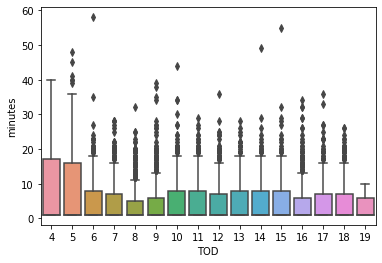

In [36]:
sns.boxplot(x="TOD", y="minutes",
            data=time_till_next_obs)

(0.0, 5.0)

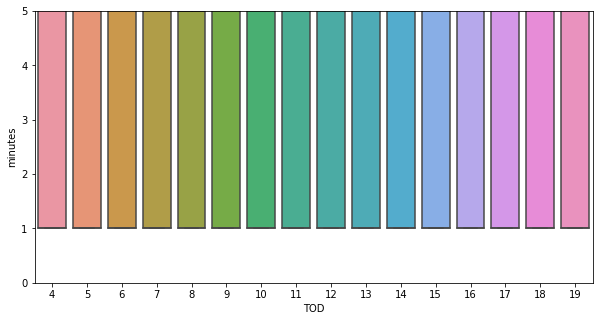

In [37]:
# It looks like there are quite a few outliers with messaging over 1 minute, but overall, updates are sub 1 minute.
# TODO: Determine if these gaps are due to failed parsing, or just updates that don't happen regularly
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))

ax = sns.boxplot(x="TOD", y="minutes", data=time_till_next_obs)
ax.set_ylim([0, 5])

### Calculate time between train departure, and the next train
Only do this between 04:00 and 19:00, as trains run sporadically outside of that date range

In [38]:
times_sq_df = stopped_at_df[['time', 'R16N']].replace(0.0, np.nan).dropna()

new_stops = times_sq_df[times_sq_df != times_sq_df.shift(1)].dropna()
new_stops['time'] = new_stops.index
new_stops.fillna(method='ffill', inplace=True)

time_till_next_obs = pd.DataFrame(columns=['time'])
# There is generally a gap between end of day and start of day, or if there are missing day
# we need to calculate time until next train within each day and not accidentally count overnight
deltas = []
new_stops = new_stops.sort_index()


for _,d in new_stops.groupby(new_stops.index.date):
    deltas.append((d.time.shift(-1) - d.time).to_frame())
#for _,d in new_stops.groupby(new_stops.index.date):
#    time_till_next_obs.loc[d.index, 'time'] = d.time.shift(-1) - d.time

time_till_next_obs = pd.concat(deltas)
time_till_next_obs = time_till_next_obs.dropna(how='all')
time_till_next_obs = time_till_next_obs.between_time('04:00','21:00')
#time_till_next_obs = (new_stops.time.shift(-1) - new_stops.time).to_frame()
time_till_next_obs['minutes'] = time_till_next_obs['time'].map(lambda x: x.total_seconds() / 60. )
time_till_next_obs['TOD'] = time_till_next_obs.index.map(lambda x: x.hour)

(0.0, 60.0)

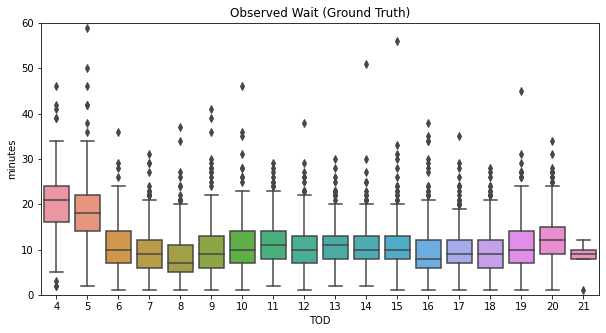

In [39]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x="TOD", y="minutes", data=time_till_next_obs)
ax.set_title("Observed Wait (Ground Truth)")
ax.set_ylim([0, 60])

In [40]:
next_scheduled_arrival_df

stop_id,101N,103N,104N,106N,107N,108N,109N,110N,111N,112N,...,S22N,S23N,S24N,S25N,S26N,S27N,S28N,S29N,S30N,S31N
2018-09-30 20:00:00-04:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-09-30 20:01:00-04:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-09-30 20:02:00-04:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-09-30 20:03:00-04:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-09-30 20:04:00-04:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 20:54:00-05:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-12-31 20:55:00-05:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-12-31 20:56:00-05:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-12-31 20:57:00-05:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# TODO Fix MTA Arrival Time predictions

In [42]:
time_till_next_obs['GroundTruth'] = time_till_next_obs['minutes']
next_ts_df = next_scheduled_arrival_df['R16N'].replace(0.0, np.nan).dropna()
scheduled_time = pd.Series(time_till_next_obs.index.map(lambda x: next_ts_df.iloc[next_ts_df.index.searchsorted(x, side='right', sorter=None)]))
scheduled_time.index = next_ts_df.index


IndexError: single positional indexer is out-of-bounds

In [43]:
%debug

> /miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py(2063)_validate_integer()
   2061         len_axis = len(self.obj._get_axis(axis))
   2062         if key >= len_axis or key < -len_axis:
-> 2063             raise IndexError("single positional indexer is out-of-bounds")
   2064 
   2065     def _getitem_tuple(self, tup: Tuple):



ipdb>  up


> /miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py(2138)_getitem_axis()
   2136 
   2137             # validate the location
-> 2138             self._validate_integer(key, axis)
   2139 
   2140             return self._get_loc(key, axis=axis)



ipdb>  up


> /miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py(1768)__getitem__()
   1766 
   1767             maybe_callable = com.apply_if_callable(key, self.obj)
-> 1768             return self._getitem_axis(maybe_callable, axis=axis)
   1769 
   1770     def _is_scalar_access(self, key: Tuple):



ipdb>  up


> <ipython-input-42-c04e2f18272b>(3)<lambda>()
      1 time_till_next_obs['GroundTruth'] = time_till_next_obs['minutes']
      2 next_ts_df = next_scheduled_arrival_df['R16N'].replace(0.0, np.nan).dropna()
----> 3 scheduled_time = pd.Series(time_till_next_obs.index.map(lambda x: next_ts_df.iloc[next_ts_df.index.searchsorted(x, side='right', sorter=None)]))
      4 scheduled_time.index = next_ts_df.index



ipdb>  next_ts_df


Series([], Name: R16N, dtype: float64)


ipdb>  next_scheduled_arrival_df


stop_id                    101N  103N  104N  106N  107N  108N  109N  110N  \
2018-09-30 20:00:00-04:00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2018-09-30 20:01:00-04:00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2018-09-30 20:02:00-04:00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2018-09-30 20:03:00-04:00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2018-09-30 20:04:00-04:00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
...                         ...   ...   ...   ...   ...   ...   ...   ...   
2018-12-31 20:54:00-05:00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2018-12-31 20:55:00-05:00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2018-12-31 20:56:00-05:00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2018-12-31 20:57:00-05:00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2018-12-31 20:58:00-05:00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

stop_id                    111N  112N  ...  S22N  S23N  S24N  S25N  S26N  \

ipdb>  q


In [43]:
time_till_next_obs['MTAPredict'] = (scheduled_time - time_till_next_obs.index).map(lambda x: x.total_seconds() / 60.0)

NameError: name 'scheduled_time' is not defined

In [44]:
wait_time = time_till_next_obs.loc[:, ['GroundTruth', 'MTAPredict', 'TOD']]

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

### Examine train status against alert data

In [45]:
# Find if alerts are predictive
# Get a list of alert times for N train
import numpy as np
alert_dir = '../data/raw/alerts'
alert_files = glob.glob(os.path.abspath(os.path.join(alert_dir, 'raw_alerts_*.csv')))
alert_list = []
for f in alert_files:
    alert_list.append(pd.read_csv(f))
alert_df = pd.concat(alert_list)
alert_df.index = alert_df.Date.map(pd.to_datetime)
alert_df.drop(columns=['Date'], inplace=True)
alert_df.sort_index(inplace=True)

In [46]:
# Train wait time
train_wait = time_till_next_obs.replace(0, np.nan).dropna()

In [47]:
print(alert_df['2018-8'])

                    Agency                                            Subject  \
Date                                                                            
2018-08-01 00:18:00    NYC  UPDATED: BKLYN, J Trains, Person Struck by a T...   
2018-08-01 01:04:00    NYC                     QNS, 7 Trains, Switch Problems   
2018-08-01 01:16:00    NYC  UPDATED: BKLYN, J Trains, Person Struck by a T...   
2018-08-01 01:20:00    NYC            UPDATED: QNS, 7 Trains, Switch Problems   
2018-08-01 01:24:00    NYC  MANH, 1 and 2 Trains, Temporary Track Maintenance   
...                    ...                                                ...   
2018-08-31 21:26:00    NYC            UPDATED: BX, D Trains, Brakes Activated   
2018-08-31 21:27:00    NYC            UPDATED: BX, D Trains, Brakes Activated   
2018-08-31 23:05:00    NYC                BKLYN, F Trains, Medical Assistance   
2018-08-31 23:09:00    NYC  BX, 2 and 5 Trains, Unauthorized person on the...   
2018-08-31 23:36:00    NYC  

In [48]:
train_alerts = alert_df.loc[alert_df.Subject.str.match(r'.* N(?:(, )|( and)).*')]
train_alerts = train_alerts.sort_index()

In [49]:
train_alerts.loc['2018-08-01':'2019-06-30'].between_time('5:00','21:00').to_csv(alert_dir+'/nqrw_alerts.csv')

In [50]:
# Add some predictors for the train_alerts
import re
subject_regex = r'^(?P<updated>UPDATED)?:? ?(?P<borough>[A-Z]+), (?P<trains>.*) Trains?, (?P<alert_type>.*)$'
message_regex = r'^(P<direction>Northbound|Southbound|Westbound|Eastbound)?.*$'


re.match(subject_regex, train_alerts.iloc[0].Subject).group('alert_type')
re.match(message_regex, train_alerts.iloc[0].Message).groups()

('Southbound',)

In [51]:
train_alerts.Message[25]

'N and R train service has resumed following an earlier incident involving a train with mechanical problems at 36 St (Bklyn).'

In [52]:
alert_features = train_alerts.Subject.str.extract(subject_regex)
alert_features['updated'] = alert_features['updated'] == 'UPDATED'

for train in ['N', 'Q', 'R', 'W']:
    alert_features[train] = alert_features['trains'].str.contains(train)
    
alert_features['direction'] = train_alerts.Message.str.extract(message_regex)[0]
alert_features['delays'] = train_alerts.Message.str.match('.*delay.*')
alert_features.drop(columns='trains')

,updated,borough,alert_type,N,Q,R,W,direction,delays
Date,,,,,,,,,
2018-01-01 00:20:00,True,MANH,Signal Problems,True,False,True,False,Southbound,True
2018-01-01 02:50:00,False,MANH,Signal Problems,True,True,False,False,Southbound,False
2018-01-01 03:12:00,True,MANH,Signal Problems,True,True,False,False,NaN,False
2018-01-01 12:24:00,False,MANH,Signal Problems,True,False,True,False,Southbound,True
2018-01-01 14:02:00,True,MANH,Signal Problems,True,False,True,False,Southbound,True
...,...,...,...,...,...,...,...,...,...
2019-06-28 10:05:00,True,MANH,Brakes Activated,True,True,False,False,Southbound,True
2019-06-28 10:05:00,True,MANH,Brakes Activated,True,True,False,False,Southbound,True
2019-06-28 18:12:00,True,MANH,Door Problem,True,False,True,True,Southbound,True


In [53]:
alert_features[ (alert_features.N == True) & alert_features.alert_type.str.contains('Brake')  ]

,updated,borough,trains,alert_type,N,Q,R,W,direction,delays
Date,,,,,,,,,,
2018-06-23 07:12:00,False,BKLYN,"D, N and R",Brakes Activated,True,False,True,False,Southbound,True
2018-06-23 07:22:00,True,BKLYN,"D, N and R",Brakes Activated,True,False,True,False,NaN,False
2018-07-04 18:02:00,False,MANH,N and R,Emergency Brakes Activated,True,False,True,False,NaN,False
2018-07-04 18:49:00,True,MANH,N and R,Emergency Brakes Activated,True,False,True,False,NaN,False
2018-07-09 17:22:00,False,MANH,"N, Q, R and W",Brakes Activated,True,True,True,True,NaN,True
...,...,...,...,...,...,...,...,...,...,...
2019-06-27 13:08:00,True,BKLYN,"D, N and R",Brakes Activated,True,False,True,False,Southbound,True
2019-06-28 09:32:00,False,BKLYN,N and R,Brakes Activated,True,False,True,False,Southbound,False
2019-06-28 09:42:00,False,MANH,N and Q,Brakes Activated,True,True,False,False,Southbound,True


In [54]:
train_alerts = alert_df.loc[alert_df.Subject.str.match(r'.* N(?:(, )|( and)).*') & alert_df.Message.str.match(r'.*delay.*')]
train_alerts = train_alerts.sort_index()

for i,ts in enumerate(train_alerts.index[:-1]):
    ts1 = pd.Timestamp(ts, tz='US/Eastern')
    ts2 = pd.Timestamp(train_alerts.index[i+1], tz='US/Eastern')
    wait_time.loc[ts1:ts2, 'LastAlertTime'] = ts1
wait_time.loc[ts2:, 'LastAlertTime'] = ts1

NameError: name 'wait_time' is not defined

In [55]:
for x,y in zip(wait_time.index, wait_time['LastAlertTime']):
    wait_time.loc[x, 'MinSinceAlert'] = (x-y).total_seconds() / 60.0

NameError: name 'wait_time' is not defined

In [56]:
alert_mask = wait_time.MinSinceAlert < 30

NameError: name 'wait_time' is not defined

In [57]:
train_wait['Alerted'] = alert_mask

NameError: name 'alert_mask' is not defined

In [58]:
# g = sns.FacetGrid(train_wait, col="Alerted", row="TOD", height=1.7, aspect=2, xlim=(0, 30), ylim=(0,.2))
# g.map(sns.distplot, "GroundTruth", color='b', label='GroundTruth')
# g.map(sns.distplot, "MTAPredict", color='r', label='MTAPredict')
# g.add_legend();


In [59]:
alert_time_mask = (wait_time.MinSinceAlert < 60) & (wait_time.TOD < 19) & (wait_time.TOD > 7)
plt.figure(figsize=(10,5))
ax = sns.distplot(wait_time['GroundTruth'].loc[alert_time_mask], kde=False, norm_hist=True, label='Ground Truth \u03BC:{:.2f}'.format(wait_time['GroundTruth'].loc[alert_time_mask].mean()))
sns.distplot(wait_time['MTAPredict'].loc[alert_time_mask], ax=ax, color='r', kde=False, norm_hist=True, label='Scheduled Arrival \u03BC:{:.2f}'.format(wait_time['MTAPredict'].loc[alert_time_mask].mean()))
ax.set_xlim([-1, 60])
ax.set_xlabel('delay minutes')
ax.legend()

NameError: name 'wait_time' is not defined

In [60]:
alert_time_mask = (wait_time.MinSinceAlert > 60) & (wait_time.TOD < 19) & (wait_time.TOD > 7)
plt.figure(figsize=(10,5))
ax = sns.distplot(wait_time['GroundTruth'].loc[alert_time_mask], kde=False, bins=500, norm_hist=True, label='Ground Truth \u03BC:{:.2f}'.format(wait_time['GroundTruth'].loc[alert_time_mask].mean()))
sns.distplot(wait_time['MTAPredict'].loc[alert_time_mask], ax=ax, color='r', kde=False, bins=500, norm_hist=True, label='Scheduled Arrival \u03BC:{:.2f}'.format(wait_time['MTAPredict'].loc[alert_time_mask].mean()))
ax.set_xlim([-1, 60])
ax.set_xlabel('delay minutes')
ax.legend()

NameError: name 'wait_time' is not defined

In [61]:
from sklearn.metrics import mean_squared_error

In [62]:
alert_time_mask = (wait_time.MinSinceAlert >=  5) & (wait_time.MinSinceAlert < 60) & (wait_time.TOD < 19) & (wait_time.TOD > 7)
mean_squared_error(y_true=wait_time['GroundTruth'].loc[alert_time_mask], y_pred=wait_time['MTAPredict'].loc[alert_time_mask], squared=False)

NameError: name 'wait_time' is not defined

In [63]:
alert_time_mask = (wait_time.MinSinceAlert >= 60) & (wait_time.TOD < 19) & (wait_time.TOD > 7)
mean_squared_error(y_true=wait_time['GroundTruth'].loc[alert_time_mask], y_pred=wait_time['MTAPredict'].loc[alert_time_mask], squared=False)

NameError: name 'wait_time' is not defined

In [64]:
from scipy.stats import ttest_ind
alert_time_mask = (wait_time.MinSinceAlert < 60) & (wait_time.TOD < 19) & (wait_time.TOD > 7)
ttest_ind(wait_time['GroundTruth'].loc[alert_time_mask].dropna(), wait_time['GroundTruth'].loc[~alert_time_mask].dropna())


NameError: name 'wait_time' is not defined

In [65]:
from scipy.stats import ks_2samp
alert_time_mask = (wait_time.MinSinceAlert < 60) & (wait_time.TOD < 19) & (wait_time.TOD > 7)
ks_2samp(wait_time['GroundTruth'].loc[alert_time_mask].dropna(), wait_time['GroundTruth'].loc[~alert_time_mask].dropna(), alternative='greater')

NameError: name 'wait_time' is not defined

# Why does it seem like Trains Run Faster after delays?

In [66]:
wait_time['Time'] = wait_time.index

NameError: name 'wait_time' is not defined

In [67]:
wait_time['RSE'] = (wait_time['GroundTruth'] - wait_time['MTAPredict']).pow(2).pow(.5)

NameError: name 'wait_time' is not defined

In [68]:
#Examine the mta scheduled arrival time error around a particularly bad alert period on 2018-08-13 21:00-4:00
sns.scatterplot(x='Time', y='RSE', data=wait_time.loc['2018-08-13 15:00-4:00':'2018-08-13 21:00-4:00'])

NameError: name 'wait_time' is not defined

In [69]:
plt.figure(figsize=(10,5))
ax = sns.scatterplot(x='Time', y='RSE', data=wait_time.loc['2018-08-01 06:00-4:00':'2018-08-31 21:00-4:00'].between_time('15:00', '21:00'))

NameError: name 'wait_time' is not defined

<Figure size 720x360 with 0 Axes>

In [70]:
plt.figure(figsize=(10,5))
fig = plt.gcf()
df = wait_time.loc['2018-08-01 06:00-4:00':'2018-08-31 21:00-4:00', 'RSE'].between_time('15:00', '21:00').resample('1H').mean().to_frame().dropna()
df['Time'] = df.index
ax = sns.barplot(x='Time', y='RSE', data=df)
fig.autofmt_xdate()

NameError: name 'wait_time' is not defined

<Figure size 720x360 with 0 Axes>

# Look at train behavior around delays

See this [AlertDash.ipynb](AlertDash.ipynb) to run a Plotly Dash page for exploring different alerts for Norhbound N trains

# TODO: Pull plotting code from Alert Dash Notebook into modules for either easy plotly plotting, or use in Dash

### Observations:
- Trains arrive faster after delay alerts, in many cases, the MTA alert goes out *after* the observed train issues.  Based on observations, this is because many delayed trains are "release" and start running a little more bunched up, so if a delay happened down-line, trains will be arriving more frequently

## Extract Features TODO: Insert example plots

After exploring the data, you can see that there are 3 obvious things that happen, in regards to delays at Times Sq-42 St.
- Trains stay at a certain station for longer than normal
    - Create a feature that is (time_in_station) per station. The amount of the the most recent train or current train spent in the station.
- Trains start making local stops during normal daytime operations ( See [N Train Schedule](https://new.mta.info/document/9511) )
    - Create a feature that is (time_since_train) per station, how long it has been since the last train departed a station
- It looks like some trains are run with very small times in the station, possibly running quickly to fill in gaps in the current trains
    - Train 'stop_per_minute' stops / minute, this is a bit tricky, since stops aren't necessarily equidistant, so this might require a weighting based on schedule arrival times
- Some trains start running backwards
    - 'stop_per_minute' should be signed, and as a far term goal, there should be southbound data added for if a train switches from northbound -> southbound -> northbound
- There are large gaps between trains that are running
    - It is quite possible that this is due to other train lines that share tracks (Q,R,W) are having issues and then delaying the N train, so one might be able to observe the above 2 issues for correlated trains, leading to these gaps

In [25]:
start_time = pd.Timestamp('2018-08-01 11:26:00-04:00', tz='US/Eastern')
end_time = pd.Timestamp('2018-08-01 15:26:00-04:00', tz='US/Eastern')
STOP_FILTER = '^.*N$'
ROUTE_FILTER = 'N'
data_dir = '../data/raw/status'

data = alerts.load_range_schedule(start_time, end_time, STOP_FILTER, ROUTE_FILTER, data_dir)
stopped_at_df = data['stopped_at']

25552526
25552646


100%|#####################################|entries: ------decode_errors:      5


New stops:
set()


In [269]:
schedule_df = data['schedule_df']

In [29]:
time_df.index

DatetimeIndex(['2018-08-01 11:38:00-04:00', '2018-08-01 11:39:00-04:00',
               '2018-08-01 11:44:00-04:00', '2018-08-01 11:55:00-04:00',
               '2018-08-01 11:56:00-04:00', '2018-08-01 12:04:00-04:00',
               '2018-08-01 12:05:00-04:00', '2018-08-01 12:06:00-04:00',
               '2018-08-01 12:14:00-04:00', '2018-08-01 12:15:00-04:00',
               ...
               '2018-08-01 14:03:00-04:00', '2018-08-01 15:10:00-04:00',
               '2018-08-01 13:24:00-04:00', '2018-08-01 15:11:00-04:00',
               '2018-08-01 15:12:00-04:00', '2018-08-01 11:47:00-04:00',
               '2018-08-01 12:49:00-04:00', '2018-08-01 13:37:00-04:00',
               '2018-08-01 11:45:00-04:00', '2018-08-01 17:25:00-04:00'],
              dtype='datetime64[ns, US/Eastern]', length=237, freq=None)

In [1]:
# relative MTADelayPredict Project
import sys
import os
import pandas as pd
import numpy as np

sys.path.append(os.path.dirname(os.path.dirname(os.path.realpath(os.path.join('DataExploration.ipynb')))))
from MTADelayPredict.utils import  stop_info
from MTADelayPredict.subway_line import SubwayLine, N_STOP_LIST
from MTADelayPredict.stop import Stop
from importlib import reload
from MTADelayPredict.data_processing import train_data, gtfs_loader

STOP_FILTER = '^.*N$'
ROUTE_FILTER = 'N'
data_dir = '../data/raw/status'

start_date = pd.Timestamp('2018-08-01 11:26:00-04:00', tz='US/Eastern')
end_date = pd.Timestamp('2018-08-01 15:26:00-04:00', tz='US/Eastern')
train_line = 'nqrw'
loader = gtfs_loader.GTFSLoader(data_dir=data_dir,
                            train_line=train_line)
loader.load_range(start_date, end_date, stop_filter=STOP_FILTER, route_filter=ROUTE_FILTER, verbose=True, schedule=True)
schedule_df = train_data.load_range_schedule(loader)
min_since_train = train_data.min_since_train(loader)
min_in_station = train_data.min_in_station(loader)

25552526
25552646


100%|#####################################|entries: ------decode_errors:      5


New stops:
{'N10S', 'D43S', 'R36S', 'R33S', 'R35S', 'R17S', 'R06S', 'N07S', 'R15S', 'N05S', 'R13S', 'R14S', 'N04S', 'R30S', 'R60S', 'R39S', 'R40S', 'R01S', 'R11S', 'R31S', 'R04S', 'N06S', 'R20S', 'R32S', 'N02S', 'Q01N', 'R34S', 'N03S', 'R03S', 'R41S', 'N08S', 'N09S', 'R09S', 'Q01S', 'R60N', 'R16S'}


In [12]:
col = '1N 1224 STL/DIT'

In [20]:

plot_df = schedule_df[['index', col]].dropna()
plot_df.index = plot_df['index']
#plot_df.drop_duplicates(keep='last', inplace=True)

In [28]:
schedule_df.index = schedule_df['index']
schedule_df.loc['2018-08-01 13:30:00':'2018-08-01 13:50:00', '1N 1224 STL/DIT'].dropna()

index
2018-08-01 13:30:00-04:00    35.0
2018-08-01 13:30:00-04:00    35.0
2018-08-01 13:31:00-04:00    35.0
2018-08-01 13:31:00-04:00    35.0
2018-08-01 13:32:00-04:00    36.0
2018-08-01 13:32:00-04:00    36.0
2018-08-01 13:32:00-04:00    36.0
2018-08-01 13:33:00-04:00    37.0
2018-08-01 13:33:00-04:00    36.0
2018-08-01 13:33:00-04:00    36.0
2018-08-01 13:34:00-04:00    37.0
2018-08-01 13:34:00-04:00    37.0
2018-08-01 13:34:00-04:00    37.0
2018-08-01 13:35:00-04:00    37.0
2018-08-01 13:35:00-04:00    37.0
2018-08-01 13:35:00-04:00    37.0
2018-08-01 13:35:00-04:00    37.0
2018-08-01 13:37:00-04:00    38.0
2018-08-01 13:37:00-04:00    38.0
2018-08-01 13:38:00-04:00    38.0
2018-08-01 13:38:00-04:00    38.0
2018-08-01 13:39:00-04:00    38.0
2018-08-01 13:39:00-04:00    38.0
2018-08-01 13:39:00-04:00    38.0
2018-08-01 13:39:00-04:00    38.0
2018-08-01 13:40:00-04:00    40.0
2018-08-01 13:40:00-04:00    40.0
2018-08-01 13:40:00-04:00    40.0
2018-08-01 13:41:00-04:00    40.0
2018-08-

In [29]:
schedule_df.loc['2018-08-01 13:30:00':'2018-08-01 13:50:00', '1N 1224 STL/DIT'].dropna().drop_duplicates(keep='last')

index
2018-08-01 13:31:00-04:00    35.0
2018-08-01 13:33:00-04:00    36.0
2018-08-01 13:35:00-04:00    37.0
2018-08-01 13:39:00-04:00    38.0
2018-08-01 13:44:00-04:00    40.0
2018-08-01 13:47:00-04:00    42.0
2018-08-01 13:50:00-04:00    43.0
Name: 1N 1224 STL/DIT, dtype: float64

In [34]:
plot_df = plot_df.loc[~plot_df.index.duplicated(keep='last')]
plot_df.loc['2018-08-01 13:30:00':'2018-08-01 13:50:00', '1N 1224 STL/DIT']

index
2018-08-01 13:30:00-04:00    35.0
2018-08-01 13:31:00-04:00    35.0
2018-08-01 13:32:00-04:00    36.0
2018-08-01 13:33:00-04:00    37.0
2018-08-01 13:34:00-04:00    37.0
2018-08-01 13:35:00-04:00    37.0
2018-08-01 13:37:00-04:00    38.0
2018-08-01 13:38:00-04:00    38.0
2018-08-01 13:39:00-04:00    38.0
2018-08-01 13:40:00-04:00    40.0
2018-08-01 13:41:00-04:00    40.0
2018-08-01 13:42:00-04:00    40.0
2018-08-01 13:43:00-04:00    40.0
2018-08-01 13:44:00-04:00    40.0
2018-08-01 13:45:00-04:00    42.0
2018-08-01 13:46:00-04:00    42.0
2018-08-01 13:47:00-04:00    43.0
2018-08-01 13:48:00-04:00    43.0
2018-08-01 13:49:00-04:00    43.0
2018-08-01 13:50:00-04:00    43.0
Name: 1N 1224 STL/DIT, dtype: float64

In [4]:
schedule_df

,level_0,index,1N 1004 STL/DIT,1N 1014 STL/DIT,1N 1024 STL/DIT,1N 1044 STL/DIT,1N 1054 STL/DIT,1N 1104 STL/DIT,1N 1114 STL/DIT,1N 1124 STL/DIT,...,1N 1344 STL/DIT,1N 1354 STL/DIT,1N 1404 STL/DIT,1N 1414 STL/DIT,1N 1424 STL/DIT,1N 1434 STL/DIT,1N 1444 STL/DIT,1N 1453 STL/DIT,1N 1512+ STL/DIT,1N 1523+ STL/DIT
0,0,2018-08-01 11:24:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2018-08-01 11:24:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2018-08-01 11:24:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2018-08-01 11:24:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2018-08-01 11:25:00-04:00,NaN,35.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4711,4711,2018-08-01 15:25:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4712,4712,2018-08-01 15:25:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN
4713,4713,2018-08-01 15:25:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN
4714,4714,2018-08-01 15:25:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN


In [4]:
OBSERVED_STOP = 'R16N'
mta_predicted = next_scheduled_df[OBSERVED_STOP].map(lambda x: pd.to_datetime(x, unit='m', utc=True).tz_convert('US/Eastern')).to_frame()
mta_predicted = mta_predicted.resample('1T').ffill()
mta_predicted.fillna(inplace=True, method='ffill')
mta_predicted['time'] = mta_predicted.index.shift(-1)

mta_predicted['wait'] = (mta_predicted[OBSERVED_STOP] - mta_predicted['time'])
mta_predicted['wait'] = mta_predicted['wait'].map(lambda x: x.delta// 60000000000)

In [5]:
OBSERVED_STOP = 'R16N'
mta_predicted = next_scheduled_df[OBSERVED_STOP].map(lambda x: pd.to_datetime(x, unit='m', utc=True).tz_convert('US/Eastern')).to_frame()
mta_predicted = mta_predicted.resample('1T').min()
mta_predicted['time'] = mta_predicted.index

mta_predicted['wait'] = (mta_predicted[OBSERVED_STOP] - mta_predicted['time'])
mta_predicted['wait'] = mta_predicted['wait'].map(lambda x: x.delta// 60000000000 if isinstance(x, pd.Timedelta) else x)

In [6]:
mta_predicted

,R16N,time,wait
2018-08-01 11:26:00-04:00,2018-08-01 11:27:00-04:00,2018-08-01 11:26:00-04:00,1
2018-08-01 11:27:00-04:00,NaT,2018-08-01 11:27:00-04:00,NaT
2018-08-01 11:28:00-04:00,NaT,2018-08-01 11:28:00-04:00,NaT
2018-08-01 11:29:00-04:00,2018-08-01 11:31:00-04:00,2018-08-01 11:29:00-04:00,2
2018-08-01 11:30:00-04:00,2018-08-01 11:31:00-04:00,2018-08-01 11:30:00-04:00,1
...,...,...,...
2018-08-01 17:21:00-04:00,NaT,2018-08-01 17:21:00-04:00,NaN
2018-08-01 17:22:00-04:00,NaT,2018-08-01 17:22:00-04:00,NaN
2018-08-01 17:23:00-04:00,NaT,2018-08-01 17:23:00-04:00,NaN
2018-08-01 17:24:00-04:00,NaT,2018-08-01 17:24:00-04:00,NaN


In [7]:
from MTADelayPredict.subway_line import SubwayLine, N_STOP_LIST
from MTADelayPredict.utils import stop_info

time_dfs = []
for stop_id,col in stopped_at_df.iteritems():
    if stop_id == 'time':
        continue
    trains = col.replace(0.0, np.nan).dropna().to_frame()
    if len(trains) == 0:
        continue
    
    departure_mask = (trains[stop_id].shift(-1) != trains[stop_id])
    arrival_mask = (trains[stop_id].shift(1) != trains[stop_id])
    trains['time'] = trains.index
    trains['departure'] = trains.index
    trains.loc[~departure_mask, 'departure'] = pd.Timestamp(np.nan, tz='US/Eastern')
    trains.loc[arrival_mask.shift(1, fill_value=False) & ~(trains['departure'].isna()), 'departure'] = 0
    trains['min_since_train'] = trains['departure'].fillna(method='ffill')
    try:
        trains['min_since_train'] = (trains['time'] - trains['min_since_train'].replace(0, pd.Timestamp(np.nan))).map(lambda x: x.delta// 60000000000 if isinstance(x, pd.Timedelta) else x)
    except Exception:
        pass
    #trains['min_since_train'] = (trains['time'] - trains['min_since_train'].replace(0, pd.Timestamp(np.nan))).map(lambda x: x.delta// 60000000000 if isinstance(x, pd.Timedelta) else x)

    trains['arrival'] = trains.index
    trains.loc[~arrival_mask, 'arrival'] = pd.Timestamp(np.nan, tz='US/Eastern')
    trains.loc[departure_mask & ~(trains['arrival'].isna()), 'arrival'] = 0
    trains['min_in_station'] = trains['arrival'].fillna(method='ffill')
    try:
        trains['min_in_station'] = (trains['time'] - trains['min_in_station']).map(lambda x: x.delta// 60000000000 if isinstance(x, pd.Timedelta) else x)
    except Exception:
        pass

    
    foo = trains.loc[:, ['min_since_train', 'min_in_station']]
    foo.columns = pd.MultiIndex.from_tuples([(stop_id, 'min_since_train'),\
                                             (stop_id, 'min_in_station')], names=['stop_id','feature'])
    time_dfs.append(foo)
time_df = pd.concat(time_dfs)
time_df.fillna(method='ffill', inplace=True)
time_df = time_df[~time_df.index.duplicated()]

/miniconda3/lib/python3.6/site-packages/pandas/core/arrays/datetimelike.py:1268: PerformanceWarning: Adding/subtracting array of DateOffsets to DatetimeArray not vectorized
  PerformanceWarning,


In [8]:
time_df = time_df[~time_df.index.duplicated()].applymap(lambda x: x.delta// 60000000000 if isinstance(x, pd.Timedelta) else x)

In [2]:
stop_id = OBSERVED_STOP
col = stopped_at_df[stop_id]
trains = col.replace(0.0, np.nan).dropna().to_frame()
departure_mask = (trains[stop_id].shift(-1) != trains[stop_id])
arrival_mask = (trains[stop_id].shift(1) != trains[stop_id])
trains['departure'] = trains.index
trains.loc[~departure_mask, 'departure'] = np.nan
trains.loc[arrival_mask.shift(1, fill_value=False) & ~(trains['departure'].isna()), 'departure'] = 0
trains['arrival'] = trains.index
trains.loc[~arrival_mask, 'arrival'] = np.nan
trains.loc[departure_mask & ~(trains['arrival'].isna()), 'arrival'] = 0
trains = trains.resample('1T').max()

trains['time'] = trains.index
trains['min_since_train'] = trains['departure'].fillna(method='ffill')
trains['min_in_station'] = trains['arrival'].fillna(method='ffill')

trains['min_since_train'] = (trains['time'] - trains['min_since_train'].replace(0, pd.Timestamp(np.nan))).map(lambda x: x.delta// 60000000000 if isinstance(x, pd.Timedelta) else x)
trains['min_in_station'] = (trains['time'] - trains['min_in_station'].replace(0, pd.Timestamp(np.nan))).map(lambda x: x.delta// 60000000000 if isinstance(x, pd.Timedelta) else x)


NameError: name 'OBSERVED_STOP' is not defined

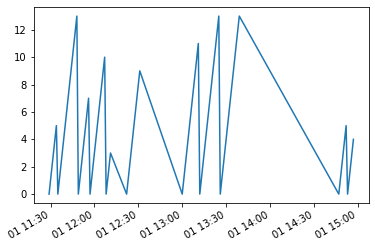

In [10]:
pd.set_option("display.max_rows", 100)
trains.min_since_train.dropna().plot()


In [11]:
print(trains.iloc[5:10])

                              R16N                  departure  \
2018-08-01 11:32:00-04:00      NaN                        NaN   
2018-08-01 11:33:00-04:00  11034.0                        NaN   
2018-08-01 11:34:00-04:00  11034.0                        NaN   
2018-08-01 11:35:00-04:00  11034.0  2018-08-01 11:35:00-04:00   
2018-08-01 11:36:00-04:00      NaN                        NaN   

                                            arrival                      time  \
2018-08-01 11:32:00-04:00                       NaT 2018-08-01 11:32:00-04:00   
2018-08-01 11:33:00-04:00 2018-08-01 11:33:00-04:00 2018-08-01 11:33:00-04:00   
2018-08-01 11:34:00-04:00                       NaT 2018-08-01 11:34:00-04:00   
2018-08-01 11:35:00-04:00                       NaT 2018-08-01 11:35:00-04:00   
2018-08-01 11:36:00-04:00                       NaT 2018-08-01 11:36:00-04:00   

                          min_since_train  min_in_station  
2018-08-01 11:32:00-04:00               3               5  
20

In [12]:
trains
departure_mask = (trains[stop_id].shift(-1) != trains[stop_id])
arrival_mask = (trains[stop_id].shift(1) != trains[stop_id])
masked_trains = trains[departure_mask | arrival_mask]
trains['time'] = trains.index
deltas = []
for _,d in trains.groupby(trains.index.date):
    deltas.append((d.time - d.time.shift(1)))
trains['time_delta'] = pd.concat(deltas)
trains['time_in_station'] = trains['time_delta']
trains['time_since_train'] = trains['time_delta']
trains.loc[~departure_mask, 'time_in_station'] = np.nan
trains.loc[~arrival_mask, 'time_since_train'] = np.nan

In [13]:
trains

,R16N,departure,arrival,time,min_since_train,min_in_station,time_delta,time_in_station,time_since_train
2018-08-01 11:27:00-04:00,11024.0,NaT,2018-08-01 11:27:00-04:00,2018-08-01 11:27:00-04:00,NaT,0,NaT,NaT,NaT
2018-08-01 11:28:00-04:00,11024.0,NaN,NaT,2018-08-01 11:28:00-04:00,NaT,1,00:01:00,NaT,NaT
2018-08-01 11:29:00-04:00,11024.0,2018-08-01 11:29:00-04:00,NaT,2018-08-01 11:29:00-04:00,0,2,00:01:00,00:01:00,NaT
2018-08-01 11:30:00-04:00,NaN,NaN,NaT,2018-08-01 11:30:00-04:00,1,3,00:01:00,00:01:00,00:01:00
2018-08-01 11:31:00-04:00,NaN,NaN,NaT,2018-08-01 11:31:00-04:00,2,4,00:01:00,00:01:00,00:01:00
...,...,...,...,...,...,...,...,...,...
2018-08-01 15:20:00-04:00,NaN,NaN,NaT,2018-08-01 15:20:00-04:00,NaT,10,00:01:00,00:01:00,00:01:00
2018-08-01 15:21:00-04:00,NaN,NaN,NaT,2018-08-01 15:21:00-04:00,NaT,11,00:01:00,00:01:00,00:01:00
2018-08-01 15:22:00-04:00,NaN,NaN,NaT,2018-08-01 15:22:00-04:00,NaT,12,00:01:00,00:01:00,00:01:00
2018-08-01 15:23:00-04:00,11424.0,NaN,2018-08-01 15:23:00-04:00,2018-08-01 15:23:00-04:00,NaT,0,00:01:00,NaT,00:01:00


In [1]:
loader = data['loader']

NameError: name 'data' is not defined

In [45]:
schedule_dfs = []
for stop, train in zip(loader.stop_dict.items(), loader.train_dict.items()):
    schedule_dfs.append(pd.DataFrame(stop[1], index=train[1], columns=[stop[0]]))
line = SubwayLine(N_STOP_LIST)
schedule_df = pd.concat(schedule_dfs)
schedule_df = schedule_df.sort_index()['2018']

In [46]:

df = schedule_df.stack().reset_index()
df.columns = ['time', 'train_id', 'stop_id']
df = df.pivot_table(index='time', columns='stop_id', values='train_id', aggfunc=np.max)
df.sort_index(inplace=True)
df = df.resample('1T').last()

In [83]:
min_in_station = df.copy()
min_in_station[~df.isna()] = 1.0
min_in_station = min_in_station.astype(float)

train_gaps = df.copy().shift(1)
train_gaps[~df.isna()] = 0.0
train_gaps.fillna(method='ffill', inplace=True)
train_gaps.replace(0.0, np.nan, inplace=True)
min_since_train = train_gaps.copy()

min_since_train[~train_gaps.isna()] = 1.0
min_since_train = min_since_train.astype(float)

In [84]:
min_until_train = min_since_train.iloc[::-1].copy()
reversed_train_gaps = train_gaps.iloc[::-1]
reversed_train_gaps = reversed_train_gaps.reset_index(drop=True)
min_until_train = min_until_train.reset_index(drop=True)

In [85]:

for observing_stop in df.columns:
    min_since_train[observing_stop] = min_since_train[observing_stop].groupby(train_gaps[observing_stop]).cumsum()
    min_in_station[observing_stop] = min_in_station[observing_stop].groupby(df[observing_stop]).cumsum()
    
    min_until_train[observing_stop] = min_until_train[observing_stop].groupby(reversed_train_gaps[observing_stop]).cumsum()
#    train_gaps = train_gaps.iloc[::-1]
#    min_until_train[observing_stop] = min_until_train[observing_stop].groupby(train_gaps[observing_stop]).cumsum()

In [87]:
min_until_train = min_until_train.iloc[::-1]
min_until_train.index = min_since_train.index

In [88]:
min_until_train

stop_id,D43N,N02N,N03N,N04N,N05N,N06N,N07N,N08N,N09N,N10N,...,R14N,R15N,R16N,R17N,R20N,R31N,R36N,R39N,R40N,R41N
time,,,,,,,,,,,,,,,,,,,,,
2018-08-01 11:24:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-08-01 11:25:00-04:00,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-08-01 11:26:00-04:00,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-08-01 11:27:00-04:00,11.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,2.0,NaN,NaN,8.0,NaN,NaN,NaN
2018-08-01 11:28:00-04:00,10.0,5.0,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,...,4.0,NaN,NaN,1.0,NaN,NaN,7.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-01 15:21:00-04:00,2.0,5.0,5.0,5.0,5.0,3.0,1.0,NaN,5.0,5.0,...,5.0,4.0,2.0,NaN,5.0,NaN,2.0,NaN,5.0,5.0
2018-08-01 15:22:00-04:00,1.0,4.0,4.0,4.0,4.0,2.0,NaN,4.0,4.0,4.0,...,4.0,3.0,1.0,NaN,4.0,NaN,1.0,3.0,4.0,4.0
2018-08-01 15:23:00-04:00,NaN,3.0,3.0,3.0,3.0,1.0,NaN,3.0,3.0,3.0,...,3.0,2.0,NaN,3.0,3.0,NaN,NaN,NaN,3.0,3.0


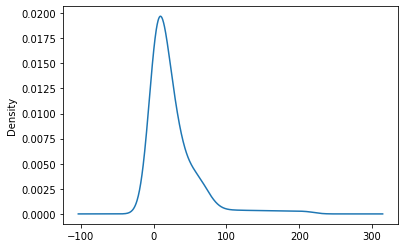

In [28]:
min_since_train['R16N'].plot.kde(x='R16N')

In [373]:

#min_since_train = pd.concat([min_since_train], axis=1, keys=['minutes'], names=['Firstlevel'])

In [374]:
def build_features(df):
    features = []
    features.append(df)
    features.append(df.rolling('5T').max())
    features.append(df.rolling('15T').max())
    features.append(df.rolling('30T').max())
    features.append(df.rolling('45T').max())
    features.append(df.rolling('60T').max())
    features.append(df.rolling('90T').max())
    return pd.concat(features, axis=1, keys=['minutes', 'max5', 'max15', 'max30', 'max45', 'max60', 'max90'], names=['transform'])

In [375]:
min_in_station = build_features(min_in_station)
min_since_train = build_features(min_since_train)
features = pd.concat([min_in_station, min_since_train], axis=1, keys=['min_in_station', 'min_since_train'], names=['feature'])

In [408]:
feature_df = features

In [377]:
features.loc[:, ('min_in_station', 'minutes', 'R16N')]

time
2018-08-01 11:24:00-04:00    NaN
2018-08-01 11:25:00-04:00    NaN
2018-08-01 11:26:00-04:00    NaN
2018-08-01 11:27:00-04:00    1.0
2018-08-01 11:28:00-04:00    2.0
                            ... 
2018-08-01 15:21:00-04:00    NaN
2018-08-01 15:22:00-04:00    NaN
2018-08-01 15:23:00-04:00    1.0
2018-08-01 15:24:00-04:00    2.0
2018-08-01 15:25:00-04:00    NaN
Freq: T, Name: (min_in_station, minutes, R16N), Length: 242, dtype: float64

In [405]:
foo = "('min_in_station', 'minutes', 'N10N')"

In [406]:
foo = re.sub(r'[\"\'\(\) ]', '', foo)
foo = foo.split(',')

In [407]:
foo

['min_in_station', 'minutes', 'N10N']

In [428]:
OBSERVED_STOP = 'R16N'
min_since_train = feature_df.loc[:, ('min_since_train', 'minutes', OBSERVED_STOP)]
predicted_value = feature_df.loc[:, ('min_since_train', 'minutes', OBSERVED_STOP)].fillna(method='ffill')
predicted_value = predicted_value.rolling('15T').max().shift(-15)
predicted_value[predicted_value < 15] = 0

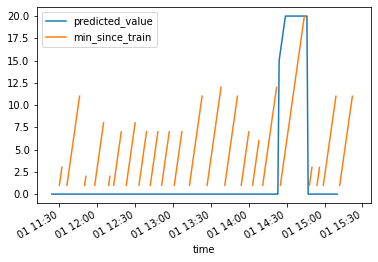

In [430]:
pd.concat([predicted_value, min_since_train], axis=1, keys=['predicted_value', 'min_since_train']).plot()

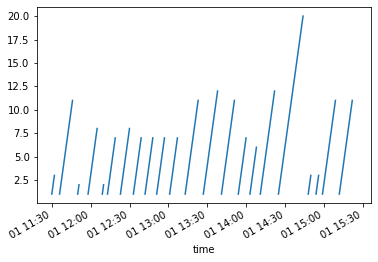

In [423]:
min_since_train.plot()

In [5]:

status_dir

'../data/raw/status/status_northbound_n'

In [100]:
import glob
import os
import pandas as pd
import numpy as np
import sys
data_dir = '../data/raw/status'

start_date = pd.Timestamp('2018-08-01 00:00:00-04:00', tz='US/Eastern')
end_date = pd.Timestamp('2019-04-30 23:59:00-04:00', tz='US/Eastern')
#end_date = pd.Timestamp('2019-03-30 23:59:00-04:00', tz='US/Eastern')

drange = pd.date_range(start_date, end_date, freq='D')

file_list = []
status_dir = os.path.join(data_dir, 'status_northbound_n_new')

min_since_train_list = []
min_in_station_list = []
min_until_train_list = []

for date in drange:
    yyyymm = str(date.year * 100 + date.month)
    yyyymmdd = str(date.year * 10000 + date.month * 100 + date.day)
    filename = os.path.join(status_dir, yyyymm, '{}.h5'.format(yyyymmdd))
    if os.path.exists(filename):
        file_list.append(filename)
        min_since_train_list.append(pd.read_hdf(filename, 'min_since_train'))
        min_in_station_list.append(pd.read_hdf(filename, 'min_in_station'))
        min_until_train_list.append(pd.read_hdf(filename, 'min_until_train'))
    else:
        print("Missing {}".format(yyyymmdd))


Missing 20181009
Missing 20181028
Missing 20181029
Missing 20181030
Missing 20181211
Missing 20190124
Missing 20190406
Missing 20190407
Missing 20190408


In [101]:
min_since_train_df = pd.concat(min_since_train_list)
min_in_station_df = pd.concat(min_in_station_list)
min_until_train_df = pd.concat(min_until_train_list)

In [102]:
# Drop outliers, anything longer than an hour maybe has issues
min_in_station_df[min_in_station_df > 60] = 60
min_since_train_df[min_since_train_df > 60] = 60
min_until_train_df[min_until_train_df > 60] = 60

In [103]:
min_since_train_log_df = min_since_train_df.applymap(np.log)
min_in_station_log_df = min_in_station_df.applymap(np.log)

In [104]:
min_until_train_log_df = min_until_train_df.applymap(np.log)

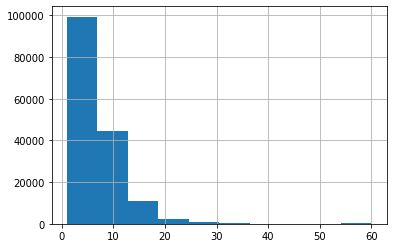

In [105]:
min_until_train_df.loc[:, 'R16N'].between_time('06:00', '19:00').hist()

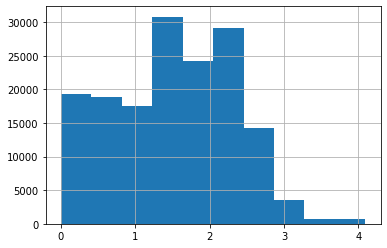

In [106]:
min_until_train_log_df.loc[:,'R16N'].between_time('06:00', '19:00').hist()

In [107]:
sys.path.append(os.path.dirname(os.path.dirname(os.path.realpath(os.path.join('DataExploration.ipynb')))))
from MTADelayPredict.features import feature_builder, delay_builder

In [108]:
features = feature_builder.FeatureBuilder(min_in_station_df, min_since_train_df)

In [56]:
features_df = features.features.between_time('06:00', '19:00').fillna(0.0)
min_until_train_log_df = min_until_train_log_df.fillna(0.0)
#min_until_train_df = min_until_train_df.between_time('06:00', '19:00').fillna(0.0)

In [52]:
from importlib import reload

In [53]:
reload(delay_builder)
delays = delay_builder.DelayBuilder(min_since_train_df, wait_threshold=20, lookahead=15, duration=15)

In [109]:
is_delay = (min_until_train_df['R16N'] > 15).between_time('06:00', '19:00')

In [59]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

test_size = .25
date_list = pd.date_range(start_date, end_date, freq='D').to_list()
n_dates = len(date_list)
test_end = date_list[int(n_dates // (1/(test_size)))]
#X_train, X_test, y_train, y_test = train_test_split(features_df.values, is_delay.values, test_size=0.33, random_state=42)
X_train = features_df[test_end:]
y_train = is_delay[test_end:]
X_test = features_df[:test_end]
y_test = is_delay[:test_end]

In [60]:
y_test.shape

(53108,)

In [61]:
clf = DecisionTreeClassifier()

In [62]:
clf.fit(X_train.values, y_train.values)

DecisionTreeClassifier()

In [63]:
from sklearn.metrics import mean_squared_error

In [64]:
y_pred = clf.predict(X_test.values)


In [65]:
y_pred_df = pd.DataFrame(y_pred, index=y_test.index)

In [66]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test.values, y_pred)

0.9538487610152896

In [67]:
(y_test == 1).sum()/(y_test == 0).sum()

0.05639209913870268

In [68]:
y_pred_df.index

DatetimeIndex(['2018-08-01 06:00:00-04:00', '2018-08-01 06:01:00-04:00',
               '2018-08-01 06:02:00-04:00', '2018-08-01 06:03:00-04:00',
               '2018-08-01 06:04:00-04:00', '2018-08-01 06:05:00-04:00',
               '2018-08-01 06:06:00-04:00', '2018-08-01 06:07:00-04:00',
               '2018-08-01 06:08:00-04:00', '2018-08-01 06:09:00-04:00',
               ...
               '2018-10-07 18:51:00-04:00', '2018-10-07 18:52:00-04:00',
               '2018-10-07 18:53:00-04:00', '2018-10-07 18:54:00-04:00',
               '2018-10-07 18:55:00-04:00', '2018-10-07 18:56:00-04:00',
               '2018-10-07 18:57:00-04:00', '2018-10-07 18:58:00-04:00',
               '2018-10-07 18:59:00-04:00', '2018-10-07 19:00:00-04:00'],
              dtype='datetime64[ns, US/Eastern]', name='time', length=53108, freq=None)

In [75]:
#y_pred_df['2018-08-16'].plot()

In [ ]:
#y_test['2018-08-16'].plot()

In [ ]:
#from sklearn.ensemble import RandomForestClassifier

In [70]:
#rfc = RandomForestClassifier(random_state=42)
#rfc.fit(X_train.values, y_train.values)

In [71]:
#y_pred = rfc.predict(X_test.values)
#y_pred_df = pd.DataFrame(y_pred, index=y_test.index)

In [72]:
#accuracy_score(y_test.values, y_pred)

In [73]:
#y_pred_df['2019-02-20'].plot()

In [74]:
#y_test['2019-02-20'].plot()

# Predict wait times

In [76]:
from sklearn.tree import DecisionTreeRegressor

In [77]:
dcr = DecisionTreeRegressor()

In [187]:
#wait_time = min_until_train_log_df['R16N'].rolling('5T').max().shift(30).between_time('06:00', '19:00').fillna(0.0)

In [329]:
wait_time = min_until_train_log_df['R16N'].between_time('06:00', '19:00').fillna(0.0)

In [330]:
features_df = features_df.fillna(method='ffill')

In [331]:
test_size = .25
date_list = pd.date_range(start_date, end_date, freq='D').to_list()
n_dates = len(date_list)
test_end = date_list[int(n_dates // (1/(test_size)))]
#X_train, X_test, y_train, y_test = train_test_split(features_df.values, is_delay.values, test_size=0.33, random_state=42)
X_train = features_df[test_end:]
y_train = wait_time[test_end:]
X_test = features_df[:test_end]
y_test = wait_time[:test_end]

In [332]:
dcr.fit(X_train, y_train)

DecisionTreeRegressor()

In [333]:
y_pred = dcr.predict(X_test)

In [334]:
mse = mean_squared_error(y_test, y_pred, squared=False)
mean_squared_error(y_test, y_pred, squared=False)

1.1612398129175865

In [335]:
print("{} min.".format(np.exp(mse)))

3.1938906492924257 min.


In [336]:
y_pred_df = pd.DataFrame(y_pred, index=y_test.index)

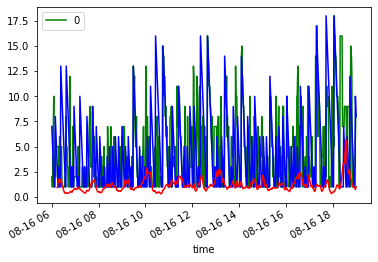

In [337]:
ax = y_pred_df['2018-08-16'].applymap(np.exp).plot(color='g')
y_test['2018-08-16'].map(np.exp).plot(ax=ax, color='b')
(y_pred_df['2018-08-16'][0] - y_test['2018-08-16']).rolling(15).mean().map(np.exp).plot(color='r', ax=ax)

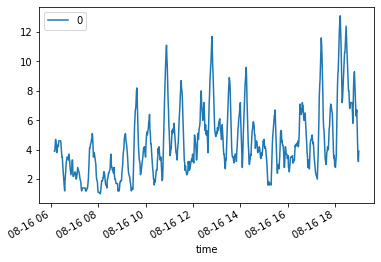

In [338]:
y_pred_df['2018-08-16'].applymap(np.exp).rolling(10).mean().plot()

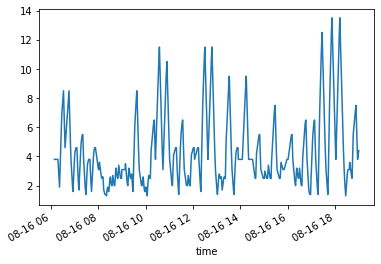

In [339]:
y_test['2018-08-16'].map(np.exp).rolling(10).mean().plot()

In [340]:
from sklearn.ensemble import GradientBoostingRegressor

In [341]:
gbr = GradientBoostingRegressor(verbose=1)

In [342]:
gbr.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.8827            5.40m
         2           0.8642            5.34m
         3           0.8478            5.27m
         4           0.8341            5.22m
         5           0.8207            5.16m
         6           0.8107            5.11m
         7           0.8006            5.05m
         8           0.7928            5.00m
         9           0.7870            4.94m
        10           0.7786            4.89m
        20           0.7417            4.34m
        30           0.7219            3.80m
        40           0.7094            3.25m
        50           0.6979            2.72m
        60           0.6888            2.18m
        70           0.6813            1.63m
        80           0.6755            1.09m
        90           0.6709           32.75s
       100           0.6647            0.00s


GradientBoostingRegressor(verbose=1)

In [343]:
y_pred = gbr.predict(X_test)

In [344]:
mse = mean_squared_error(y_test, y_pred, squared=False)
mse

0.8426289574523177

In [345]:
print("{} Minutes".format(np.exp(mse)))

2.3224646187156606 Minutes


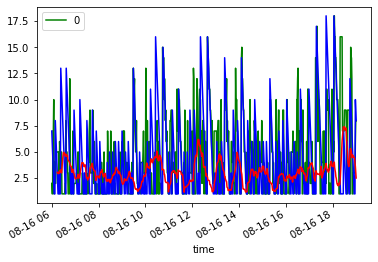

In [346]:
ax = y_pred_df['2018-08-16'].applymap(np.exp).plot(color='g')
y_test['2018-08-16'].map(np.exp).plot(ax=ax, color='b')
(y_pred_df['2018-08-16'][0] - y_test['2018-08-16']).map(lambda x: x**2).rolling(15).mean().map(np.sqrt).map(np.exp).plot(color='r', ax=ax)

In [347]:
y_pred_df['2018-08-16'][0] 

time
2018-08-16 06:00:00-04:00    0.693147
2018-08-16 06:01:00-04:00    0.000000
2018-08-16 06:02:00-04:00    0.000000
2018-08-16 06:03:00-04:00    1.945910
2018-08-16 06:04:00-04:00    1.945910
                               ...   
2018-08-16 18:56:00-04:00    1.098612
2018-08-16 18:57:00-04:00    1.098612
2018-08-16 18:58:00-04:00    1.791759
2018-08-16 18:59:00-04:00    2.079442
2018-08-16 19:00:00-04:00    2.079442
Name: 0, Length: 781, dtype: float64

In [86]:
from sklearn.ensemble import RandomForestRegressor

rfr=RandomForestRegressor(random_state=42)
rfr.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
y_pred = rft.predict(X_test)

In [ ]:
y_pred_df = pd.DataFrame(y_pred, index=y_test.index)

In [ ]:
mean_squared_error(y_test, y_pred, squared=False)

In [ ]:
y_pred_df['2018-08-16'].plot()

In [ ]:
y_test['2018-08-16'].plot()